In [2]:
import os
import openai
from typing import TypedDict
from fastapi import FastAPI
from pydantic import BaseModel
import uvicorn
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from langgraph.graph import END, START, StateGraph
import torch
from transformers import ElectraForPreTraining ,ElectraTokenizerFast


c:\Users\USER\EduEvalAI\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Set your OpenAI API key
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

# Define Input and Output State
class InputState(TypedDict):
    suggested_answer: str
    student_answer: str

class OutputState(TypedDict):
    llm_score: float
    llm_feedback: str
    sbert_score: float
    roberta_score:float
    distilroberta_score:float
    t5_score:float
    minilm_score:float
    electra_score:float
    labse_score:float


app = FastAPI()


In [4]:
#---------------------------------------------------------------------- 
#                       Open AI model 
#----------------------------------------------------------------------
def llm_evaluation_node(state: InputState) -> OutputState:
    """Use OpenAI API to evaluate the student answer and return llm_score with feedback."""
    
    prompt = f"""
    Suggested answer: "{state['suggested_answer']}"
    Student’s answer: "{state['student_answer']}"
    
    Evaluate how well the student’s answer matches the suggested answer on a scale from 0 to 10,
    considering correctness, completeness, and clarity. Provide a numeric score followed by a one-line feedback.
    Example: "8.5 - Good answer but slightly lacks depth."
    """
    try:
        response = openai.ChatCompletion.create(
            model="gpt-4",
            messages=[{"role": "system", "content": "You are an AI grader that evaluates student answers."},
                      {"role": "user", "content": prompt}],
            max_tokens=100,
            temperature=0
        )
        output = response["choices"][0]["message"]["content"].strip()

        if " - " in output:
            score, feedback = output.split(" - ", 1)
            score = float(score)
        else:
            score = 0.0
            feedback = "No valid feedback provided."
        
        print(f"LLM Evaluation Result: score={score}, feedback={feedback}")
    except Exception as e:
        print(f"Exception in LLM evaluation: {e}")
        score = 0.0
        feedback = "Error in LLM evaluation."
    
    # Update and return the state
    state["llm_score"] = score
    state["llm_feedback"] = feedback
    return state
        


In [5]:
#---------------------------------------------------------------- 
#                       SBERT Model 
#----------------------------------------------------------------
sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

def sbert_evaluation_node(state: InputState) -> OutputState:
    """Use SBERT to calculate the cosine similarity between suggested_answer and student_answer."""
    try:
        sentences = [state['suggested_answer'], state['student_answer']]
        embeddings = sbert_model.encode(sentences)
        similarity = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
        scaled_score = similarity * 10  # Scale similarity to 0-10
        
        print(f"SBERT Similarity Score: {scaled_score}")
    except Exception as e:
        print(f"Exception in SBERT evaluation: {e}")
        scaled_score = 0.0
    
    # Update and return the state
    state["sbert_score"] = scaled_score
    return state


In [6]:
#---------------------------------------------------------------- 
#                     Distiilroberta Model
#----------------------------------------------------------------
distilroberta_model = SentenceTransformer('all-distilroberta-v1')

def distilroberta_evaluation_node(state:InputState)->OutputState:
    """
    Use a DistilRoBERTa-based model (via SentenceTransformer) to calculate
    the cosine similarity between suggested_answer and student_answer,
    and scale the result from 0–10.

    :param state: A dictionary with keys 'suggested_answer' and 'student_answer'.
    :return: The updated dictionary with a new key 'distilroberta_score'.
    """

    try:
        sentences= [state['student_answer'],state['suggested_answer']]
        embeddings = distilroberta_model.encode(sentences)
        similarity = cosine_similarity([embeddings[0]],[embeddings[1]])[0][0]

        scaled_score = similarity*10

    except Exception as e:
        scaled_score=0.0

    state["distilroberta_score"] = scaled_score
    return state      

In [7]:
#---------------------------------------------------------------- 
#                      Roberta Model
#---------------------------------------------------------------- 
roberta_model = SentenceTransformer('all-roberta-large-v1')

def roberta_evaluation_node(state: InputState) -> OutputState:
    """
    Use a RoBERTa-based model (via SentenceTransformer) to calculate
    the cosine similarity between suggested_answer and student_answer,
    and scale the result from 0–10.

    :param state: A dictionary with keys 'suggested_answer' and 'student_answer'.
    :return: The updated dictionary with a new key 'roberta_score'.
    """
    try:
        # 1. Extract the two answers from the state
        sentences = [state['suggested_answer'], state['student_answer']]
        
        # 2. Encode both answers using the RoBERTa model
        embeddings = roberta_model.encode(sentences)
        
        # 3. Compute cosine similarity (range: 0 to 1)
        similarity = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
        
        # 4. Scale similarity to a 0–10 range
        scaled_score = similarity * 10
        
        print(f"RoBERTa Similarity Score: {scaled_score:.2f}")
    except Exception as e:
        print(f"Exception in RoBERTa evaluation: {e}")
        scaled_score = 0.0
    
    # 5. Update and return the state with the new score
    state["roberta_score"] = scaled_score
    return state



In [8]:
#---------------------------------------------------------------- 
#                      t5 model 
#----------------------------------------------------------------
t5_model = SentenceTransformer("sentence-t5-base")

def t5_evaluation_node(state:InputState)-> OutputState:
    """
    Use a T5-based model ti calculate the cosine similarity between suggested_answer and student_answer, 
    then scale the result from 0-10.
    """

    try:
        sentences =[state["suggested_answer"],state["student_answer"]]

        embeddings = t5_model.encode(sentences)

        similarity = cosine_similarity([embeddings[0]],[embeddings[1]])[0][0]

        scaled_score = similarity *10
      
        print("t5_score",scaled_score)

    except Exception as e:   
        scaled_score:0.0

    state["t5_score"]= scaled_score
    return state    



In [9]:
#---------------------------------------------------------------- 
#                      Minilm model
#---------------------------------------------------------------- 

minilm_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

def minilm_evaluation_node(state:InputState)->OutputState:
      """
    Use a MiniLM-based model (via SentenceTransformer) to calculate
    the cosine similarity between suggested_answer and student_answer,
    then scale the result from 0–10.
    
    :param state: A dictionary with keys 'suggested_answer' and 'student_answer'.
    :return: The updated dictionary with a new key 'minilm_score'.
    """
      try:
          
          sentences = [state["suggested_answer"],state["student_answer"]]

          embeddings = minilm_model.encode(sentences)

          similarity = cosine_similarity([embeddings[0]],[embeddings[1]])[0][0]

          scale_score = similarity*10

      except Exception as e:
          scale_score = 0.0

      state["minilm_score"]=scale_score
      return state    



In [18]:
#---------------------------------------------------------------- 
#                      Lang Graph 
#----------------------------------------------------------------
builder = StateGraph(InputState, OutputState)

builder.add_node("llm_node", llm_evaluation_node)
builder.add_node("sbert_node", sbert_evaluation_node)
builder.add_node("roberta_node",roberta_evaluation_node)
builder.add_node("distilroberta_node",distilroberta_evaluation_node)
builder.add_node("t5_node", t5_evaluation_node)
builder.add_node("minilm_node",minilm_evaluation_node)
#builder.add_node("electra_node",electra_evaluation_node)
#builder.add_node("labse_node",labse_evaluation_node)

# Define flow of the graph
#builder.add_edge(START, "llm_node")
builder.add_edge(START, "sbert_node")
builder.add_edge("sbert_node", "roberta_node")
builder.add_edge("roberta_node", "distilroberta_node")
builder.add_edge("distilroberta_node", "minilm_node")  # Fixed node name
builder.add_edge("minilm_node", END)
builder.add_edge("distilroberta_node", "t5_node")  # Additional path
builder.add_edge("t5_node", END)
#builder.add_edge("electra_node","labse_node")
#builder.add_edge("labse_node",END)
graph = builder.compile()


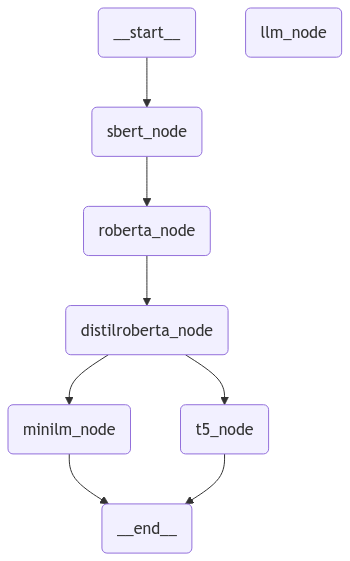

In [19]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [12]:
#---------------------------------------------------------------- 
#                   FastAPI BaseModel
#----------------------------------------------------------------
class Item(BaseModel):
    suggested_answer: str
    student_answer: str
    

In [13]:
#---------------------------------------------------------------------- 
#                     FastAPI endpoint for Evaluation
#----------------------------------------------------------------------
@app.post("/evaluate")
async def evaluate_item(item: Item):
    state = {
        "suggested_answer": item.suggested_answer,
        "student_answer": item.student_answer
    }
    
    # Invoke the graph
    try:
        result = graph.invoke(state)
        #state = llm_evaluation_node(state)
        state = sbert_evaluation_node(state)
        state = roberta_evaluation_node(state)
        state = distilroberta_evaluation_node(state)
        state = t5_evaluation_node(state)
        state = minilm_evaluation_node(state)
       # state = electra_evaluation_node(state)
       # state = labse_evaluation_node(state)
        
        # Combine and return the results
        return state
    except Exception as e:
        print(f"Exception during graph invocation: {e}")
        return {
            "llm_score": 0.0,
            "llm_feedback": "Error during evaluation.",
            "sbert_score": 0.0,
            "roberta_score":0.0,
            "distilroberta_score":0.0,
            "t5_score":0.0,
            "minilm_score":0.0,
            "electra_score":0.0,
            "labse_score":0.0
        }



In [15]:
#---------------------------------------------------------------- 
#                       Run FastAPI
#----------------------------------------------------------------
if __name__ == "__main__":
    uvicorn.run(app, host="127.0.0.1", port=7100)


RuntimeError: asyncio.run() cannot be called from a running event loop